#Интеграция. Итоговый проект/client

Строим запрос к нашему сервису

In [5]:
import requests

import urllib.request
import json 

In [17]:
# Пример данных
data = ( 
    "Silent",
    1908,
    1985
)

In [19]:
# формируем запрос
def send_json(x):
    generation, gdp_per_capita, year = x
    #print(generation, gdp_per_capita, year)
    body = {
        "generation": generation,
        'gdp_per_capita ($)': gdp_per_capita,
        "year": year
        }
    myurl = 'http://efec-35-237-36-97.ngrok.io' + '/predict'
    headers = {'content-type': 'application/json; charset=utf-8'}
    response = requests.post(myurl, json=body, headers=headers)
    return response.json()['predictions']

    

In [21]:
# обращение к серверу с запросом из одного набора (его построили руками выше - data)
response = send_json(data)
print('предсказание', response)

предсказание 8.119239389201185


Сделаем обработку массы запросов:

1) загрузим данные X_test

https://drive.google.com/file/d/19ybf27NHtT7MJYj_3eiDqFuk3mX3409m

https://drive.google.com/file/d/1skm7ty_o59ubqWQKRC444woexWa-XRer





In [24]:
!wget 'https://drive.google.com/uc?export=download&id=19ybf27NHtT7MJYj_3eiDqFuk3mX3409m' -O X_test.csv
!wget 'https://drive.google.com/uc?export=download&id=1skm7ty_o59ubqWQKRC444woexWa-XRer' -O y_test.csv

--2022-04-20 04:34:40--  https://drive.google.com/uc?export=download&id=19ybf27NHtT7MJYj_3eiDqFuk3mX3409m
Resolving drive.google.com (drive.google.com)... 142.250.141.138, 142.250.141.139, 142.250.141.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/al97un22e0enepnuln7et6c154sh30e7/1650429225000/11422071002972207359/*/19ybf27NHtT7MJYj_3eiDqFuk3mX3409m?e=download [following]
--2022-04-20 04:34:41--  https://doc-0o-9s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/al97un22e0enepnuln7et6c154sh30e7/1650429225000/11422071002972207359/*/19ybf27NHtT7MJYj_3eiDqFuk3mX3409m?e=download
Resolving doc-0o-9s-docs.googleusercontent.com (doc-0o-9s-docs.googleusercontent.com)... 142.250.141.132, 2607:f8b0:4023:c0b::84
Connecting to doc-0o-9s-docs.googleusercontent.com (doc-0o-9s

In [25]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from urllib import request, parse

#visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

In [26]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 250], [0, 250], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()

2) Передаем одиночный запрос из наших данных и посмотрим на ответ

In [27]:
response = send_json([X_test["generation"].iloc[0], int(X_test["gdp_per_capita ($)"].iloc[0]), int(X_test["year"].iloc[0])])

In [28]:
response

0.9540368694978252

In [29]:
X_test[["generation", "gdp_per_capita ($)", "year"]].head()

,generation,gdp_per_capita ($),year
0,Generation Z,47206,2015
1,Silent,912,2001
2,Generation X,3885,2013
3,G.I. Generation,1908,1987
4,Silent,4583,2003


3) Сделаем N запросов и оценим время

In [30]:
N = 50

In [31]:
%%time
predictions = X_test[
                     ["generation", "gdp_per_capita ($)", "year"]
                     ].iloc[:N].apply(lambda x: send_json(x), axis=1)

CPU times: user 185 ms, sys: 15.4 ms, total: 201 ms
Wall time: 8.78 s


In [32]:
predictions.values[:10]

array([ 0.95403687, 47.70278885, 10.58481745,  7.40664641, 18.00017095,
       18.57460607,  1.09449213,  2.25527128,  7.19659809,  0.71548211])

4) Посчитаем метрику

In [33]:
y_test.head()

,suicides/100k pop
0,0.10
1,13.92
2,2.54
3,0.00
4,0.00


R2:	-0.314
RMSE:	12.48
MSE:	155.738


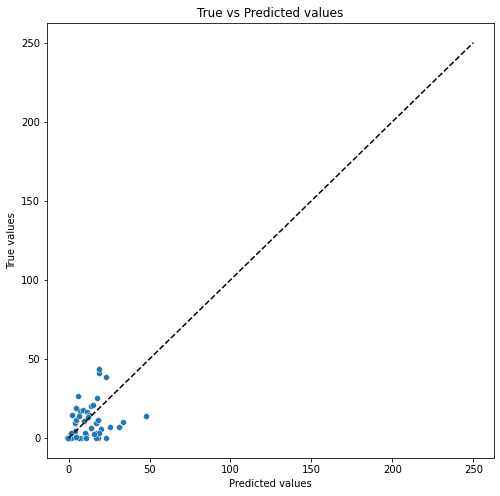

In [34]:
evaluate_preds(y_test['suicides/100k pop'].tolist()[:N], predictions)

5) Анализ: Качество модели заметно ухудшилось.